## Fitting a function with *gradient descent*

First, let's import our Jupyter notebook UI components and the fastai basic libraries.

In [1]:
from ipywidgets import interact
from fastai.basics import *

Next, let's define a function, called `plot_function` that plots a function `f`.

In `pytorch` and similar libraries like `numpy`, you need to define your inputs `x`
as a list of values, the `linspace` function does this for you, the example below
creates a list of values from our `min` parameter to the `max` parameter with 100
discrete values between them.

In [2]:
plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

Now, let's create a function `f`, that returns a quadratic function $ax^2+bx+c$.

In our function `f` below, we've hardcoded the values `a`, `b`, and `c` to `3`
, `2`, and `1` respectively.

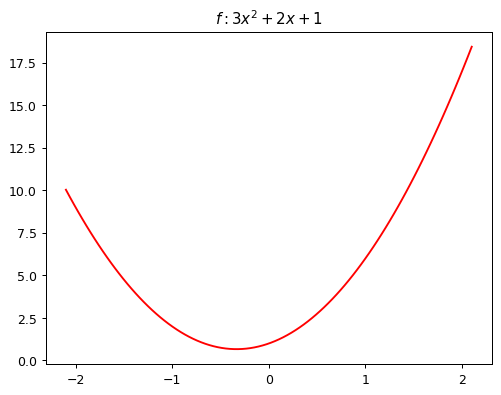

In [3]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$f:3x^2 + 2x + 1$")

Let's iterate on our function `f`, by making a more general quadratic function
named `quad` which takes in as input our coefficients `a`, `b`, and `c` along with
`x`.

In [4]:
def quad(a, b, c, x): return a*x**2 + b*x + c

Normally, we do not consider the discrete values of x when talking about math equations,
we think about it as a complete range. The `partial` function in python allows us
to fix the values of `a`, `b`, and `c`. `mk_quad` returns a function that only takes in 
`x` as an input, by fixing the values of it's constant coefficients.

In [5]:
def mk_quad(a,b,c): return partial(quad, a,b,c)

Let's recreate our original quadratic `f`, now called `f2` using `mkquad` helper function.
We'll also plot it, to visually confirm we're creating the same function, the two plots
we've generated should match.

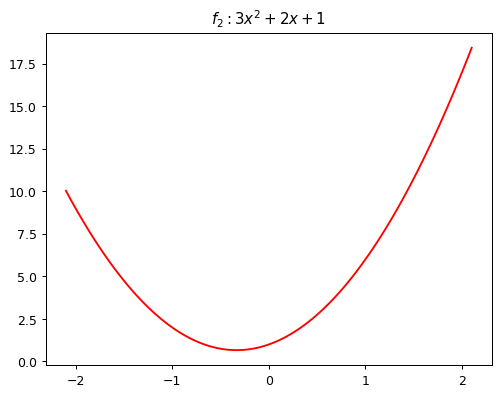

In [6]:
f2 = mk_quad(3,2,1)
plot_function(f2, "$f_2:3x^2 + 2x + 1$")

Now, to start approximating this function using machine learning. Let's create
some "test" data by using two functions, `noise` and `add_noise`. `noise` draws 
random values from a normal distribution, using `scale` as the standard deviation.

`add_noise` takes some domain `x`, and then scales and translates the points in `x` randomly.

In [7]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

In [8]:
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

In [9]:
x[:5],y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[11.8690],
         [ 6.5433],
         [ 5.9396],
         [ 2.6304],
         [ 1.7947]], dtype=torch.float64))

If we plot `x` and `y` this will make more sense but it is good to understand the
code as well.

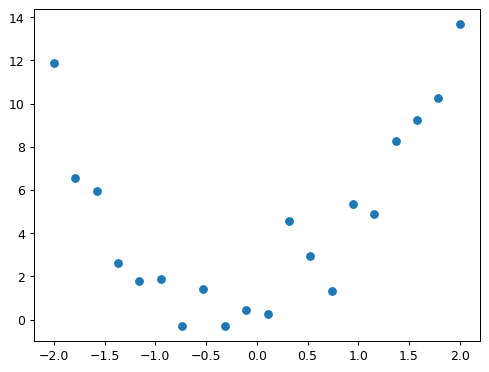

In [10]:
plt.scatter(x,y);

Now let's create a function `plot_quad` that plots our quadratic function and also has "sliders"
attached to it that allows us to manipulate the values of our constants.

Play around with the sliders and see how the lines either "approaches" our data or
"moves away" from it.

In [11]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c), ylim=(-3,13))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

How can we gain insight into how "correct" our guess was? Well we can calculate the average
error between the predicted values in our "red" line, and the corresponding "blue" points.
The `mae` function does just that.

In [13]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()

Now we can see how our loss *changes* as we change the values of our constants.

Play around with the sliders for a bit and try to get the MSE as low as possible,
I was able to get down to 1.03 after some trial and error.

In [14]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

## Automating gradient descent

That manual process you just played with is how computers can solve problems like
this one automatically, by trying to minimize our **loss function**
(the average error between the predicted values and the actual values).

In [15]:
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

In [16]:
quad_mae([1.1, 1.1, 1.1])

tensor(2.4219, dtype=torch.float64)

Now instead of using a python list for our function coefficients, let's use a tensor.

In [17]:
abc = torch.tensor([1.1,1.1,1.1])

The gradient of a function defines the rate at which it's
value changes as we change the values of the input variables. `requires_grad` is
a function that calculates the gradient of every value in our tensor `abc` for us
as computations are made using the tensor.

In [18]:
abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

So now, if we calculate the loss of our function, we'll get the gradient of the 
loss for each coefficient!

In [19]:
loss = quad_mae(abc)
loss

tensor(2.4219, dtype=torch.float64, grad_fn=<MeanBackward0>)

Now let's compute the gradient on this tensor and all of the tensors involved in calulating
it, *ahem* like the `abc` tensor!

In [20]:
loss.backward()

Now if we call `.grad` on `abc`, we'll get the gradient of each parameter!

In [21]:
abc.grad

tensor([-1.3529, -0.0316, -0.5000])

Now what if we updated our parameters by subtracting the gradient from them? Would our loss go down?

In [22]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mae(abc)
    
print(f'loss={loss:.2f}')

loss=2.40


It did! Only by a little bit though, what if we iterated on that, I don't know... say 10 times?

In [23]:
for i in range(10):
    loss = quad_mae(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss:.2f}')

step=0; loss=2.40
step=1; loss=2.36
step=2; loss=2.30
step=3; loss=2.21
step=4; loss=2.11
step=5; loss=1.98
step=6; loss=1.85
step=7; loss=1.72
step=8; loss=1.58
step=9; loss=1.46


Notice how with every "step" our loss value shrinks! Isn't that cool?

## How a neural network approximates any given function

Now let's introduce a new kind of function called the "Relu" function.
It returns 0 up until some point, and then return the original value after that.

In [26]:
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.)

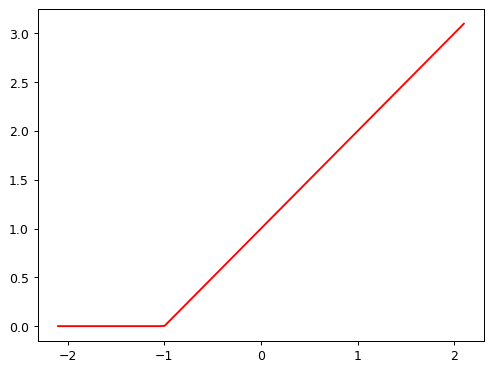

In [27]:
plot_function(partial(rectified_linear, 1,1))

Instead of defining it manually, we can just use the pytorch built in definition.

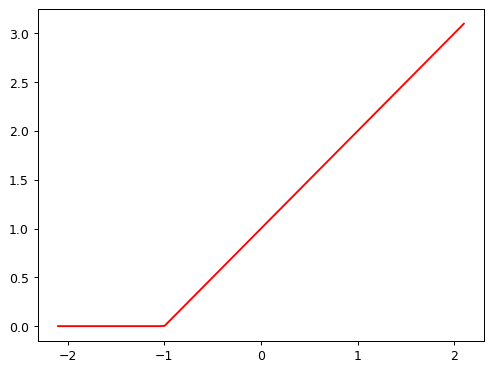

In [29]:
import torch.nn.functional as F
def rectified_linear2(m,b,x): return F.relu(m*x+b)
plot_function(partial(rectified_linear2, 1,1))

Play around with `m` and `b` to see how the function changes. You'll notice that
`m` controls the steepness of the function, and `b` controls where it starts.

In [30]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m,b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

What happens if we add two `relu` functions together?

In [31]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

We can manipulate their parameters, in this case making `m1` negative, to create an almost
curve-like function! Imagine if we had 100 relu's! We could make a curve that looks almost
exactly like our original function!